In [2]:
import csv
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib as mpl
import scipy
import math
import copy
import os
from datetime import datetime
import random
import multiprocessing
import importlib
import inspect
import pickle
import random
import warnings

import bioscrape as bs
import bioscrape.lineage as bs_lineage

import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
# sns.set(rc=rc)
# sns.set(style = "ticks")

sns.set_context('paper')

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

In this notebook, we're going to look for some (approximate) analytic solutions of steady-state DNA copy number for the Brendel & Perelson ColE1 and simplified ColE1 replication systems, with the aim of helping selection and tuning of parameters for different target copy numbers. 

# Utility functions

In [3]:
def make_growth_model(rxns, species, params, initial_conditions):
    '''
    Adds some scaffolding to a model to put it in an exponentially-growing cell 
    with growth rate params['k_gamma']. Parameters are of the same type and 
    specification as used by bioscrape.types.Model.
    '''
    m = bs_lineage.LineageModel(reactions = rxns, 
                              parameters = params,
                              species = species,
                              initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if there's 
    # no DNA present. 
    m.create_volume_rule("ode", {"equation": "volume * _k_gamma * Heaviside(DNA-1)"})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

# Simplified ColE1 replication steady state

To reiterate, the simplified ColE1 replication system is:

In [4]:
def make_simplified_BP_model(params, initial_conditions, lineage = False):
    species = ["DNA", "DNAp", "R"]

    reactions = [
        (["DNA"], ["DNAp"], "massaction", {"k": "k_p"}),
        (["DNAp"], ["DNA", "DNA"], "massaction", {"k": "k_rep"}),
        (["DNA"], ["DNA", "R"], "massaction", {"k": "k_tx"}),
        (["DNAp", "R"], ["DNA"], "massaction", {"k": "k_I"}),
        (["R"], [], "massaction", {"k": "k_gamma_I"})
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

For reference, nondimensionalized simplified ColE1 parameters as estimated from data produced with the full ColE1 model (using published parameters for that model). 

In [5]:
default_simplified_bp_params = dict()
default_simplified_bp_params["k_rep"] = 14.156455
default_simplified_bp_params["k_tx"] = 252.232848
default_simplified_bp_params["k_I"] = 0.665226
default_simplified_bp_params["k_p"] = 36.603267
default_simplified_bp_params["k_gamma_I"] = 12.534647
default_simplified_bp_params["k_gamma"] = 1.0

Some important (necessary, but possibly not sufficient) assumptions for the ColE1 system to even have a non-zero steady state:

1) $k_p \geq \gamma$ and $k_{rep} \geq \gamma$. Otherwise, dilution will always out-compete replication and the population will go to zero steady-state.

2) $k_{tx} \geq k_p$. Otherwise, inhibition by RNAI can never catch up with replication, and the plamid's population will explode to infinity. 

By way of demonstration:

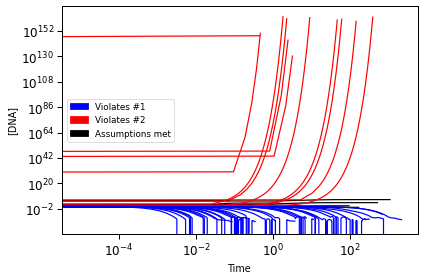

In [6]:
iters = 50
random.seed(3425)
species_inits = {"DNA": 1}

for i in range(iters):
    temp_params = dict()
    # Sample log-parameters from U(-2,3).
    for param in ["k_rep", "k_tx", "k_I", "k_p", "k_gamma_I", "k_gamma"]:
        temp_params[param] = 10 ** (random.random()*6 - 2)
    #satisfies_assumptions = temp_params["k_I"]*10 < temp_params["k_gamma_I"]
    
    # Check for 0 steady state
    if min(temp_params["k_p"], temp_params["k_rep"]) < temp_params["k_gamma"]:
        regime_color = "blue"
    # Check for infinite steady state
    elif temp_params['k_p'] > temp_params['k_tx']:
        regime_color = "red"
    else:
        regime_color = "black"
        

    # Simulate until steady-state.
    t_max = 100*np.log(2)/temp_params['k_gamma'] # Start with ~10 doubling times
    ts = np.linspace(0, t_max, 1000)
    simplified_m = make_simplified_BP_model(temp_params, species_inits, lineage = False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        simple_bp_df = bs.simulator.py_simulate_model(ts, Model = simplified_m)
        
    plt.plot(simple_bp_df["time"], simple_bp_df["DNA"] + simple_bp_df["DNAp"], 
             color = regime_color)

handles = [mpl.patches.Patch(color = 'blue', label = "Violates #1"),
           mpl.patches.Patch(color = 'red', label = "Violates #2"),
           mpl.patches.Patch(color = 'black', label = "Assumptions met")]
plt.legend(handles = handles)

plt.xlabel("Time")
plt.ylabel("[DNA]")
# plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

From here out, we'll only use parameter sets (for the simplified ColE1 model) generated so that both assumptions required for finite, non-zero steady-state are met. 

Two different regimes of the simplified ColE1 model each have a reasonably accurate approximate steady state formula:

#### Regime 1) $k_{rep} > k_p$

In this regime, plasmids are slow to enter a "replicating state" ($DNA_p$), but relatively fast to finish replicating once they begin. Once a plasmid enters the replicating state, it can either finish replicating or be terminated by binding of an RNAI ($R$) molecule; these two reactions compete over a rate-limited pool of $DNA_p$, and the probability of a particular $DNA_p$ going down either reaction path is proportional to that reaction's propensity:

$$P(\text{replication}|\text{in state }DNA_p) = \frac{k_{rep}}{k_{rep} + k_I*R}$$

We will assume that $R$ comes to equilibrium quickly relative to replication, and that $DNA_p$ is rare (and therefore annihilation between $R$ and $DNA_p$ contributes little to the equilibrium concentration of $R$) so that

$$R \approx \frac{k_{tx}*DNA}{\gamma + \gamma_I}$$

Substituting this, we have

$$P(\text{replication}|\text{in state }DNA_p) \approx \frac{k_{rep}}{k_{rep} + DNA\frac{k_Ik_{tx}}{\gamma + \gamma_I}}$$

The total rate of replication of the plasmid is the this probability multiplied by the rate at which the plasmid enters the replicating state ($k_p$). At steady state, this flux must be balanced against dilution $\gamma$, so 

$$\frac{k_p*k_{rep}}{k_{rep} + DNA\frac{k_Ik_{tx}}{\gamma + \gamma_I}} = \gamma$$

Note that this equation is written in terms of the concentration of $DNA$, *not* the concentration of *total* DNA ($DNA + DNA_p$), but since we are assuming that transition into the replicating state is slow, most DNA should be in the un-replicating state, so $DNA \approx DNA_{total}$. Solving for $DNA$, we then have

$$DNA_{total} \approx DNA = \frac{k_{rep}(k_p - \gamma)(\gamma + \gamma_I)}{k_{tx}k_I\gamma}$$

#### Regime 2) $k_{rep} < k_p$

In this regime, plasmid will readily enter a replicating state $DNA_p$, but replication from that state is slow. Here, it is most useful to think of the replication initiation reaction and the RNAI annihilation reaction as forming a rapid equilibrium between $DNA$ and $DNA_p$, with total replication rate being the rate constant $k_{rep}$ times the amount of $DNA_p$ at this equilibrium. 

We can write the equilibrium condition as

$$k_I*R*DNA_p = k_p*DNA$$

We again substitute a quasi-steady-state value of $R$, but since flux into $DNA_p$ is relatively large (or at least isn't guaranteed to be small), we have to account for $DNA_p$'s contribution to $R$'s equilibrium:

$$\frac{dR}{dt} = k_{tx} DNA - (\gamma+\gamma_I)R - k_I DNA_p R$$

$$\text{At steady state: } R = \frac{k_{tx}DNA}{(\gamma+\gamma_I) + k_IDNA_p}$$

Substituting into the equilibrium condition on $DNA$ and $DNA_p$:

$$k_I*DNA_p*\frac{k_{tx}DNA}{(\gamma+\gamma_I) + k_IDNA_p} = k_p*DNA$$

or 

$$DNA_p = \frac{k_p(\gamma + \gamma_I)}{k_I(k_{tx} - k_p)}$$

Perhaps surprisingly (or perhaps not, given its similarity to sequestration-based feedback controllers), the steady-state concentration of $DNA_p$ in this regime is (approximately) constant with respect to total $DNA$ concentration. Regardless, the total replication rate is this quantity times $k_{rep}$, and, as above, steady state occurs when this rate balances with dilution of plasmid:

$$\frac{k_{rep}k_p(\gamma + \gamma_I)}{k_I(k_{tx} - k_p)} = \gamma * DNA_{total}$$

which gives

$$DNA_{total} = \frac{k_{rep}k_p(\gamma + \gamma_I)}{\gamma k_I(k_{tx} - k_p)}$$

#### Verification

We can verify these steady-state formulae empirically by simulating with random parameters, chosen to meet the finite steady state conditions listed earlier. 

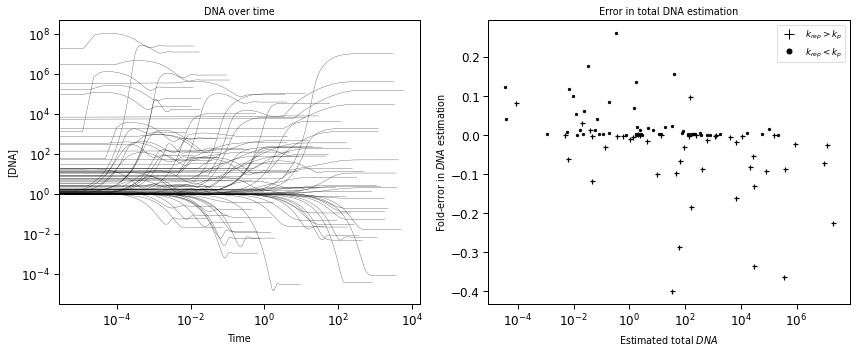

In [7]:
iters = 100
random.seed(3425)
species_inits = {"DNA": 1}

plt.figure(figsize = (12, 5))
for i in range(iters):
    temp_params = dict()
    semirandom_val = lambda:10 ** (random.random()*6 - 2)
    temp_params['k_gamma'] = semirandom_val()
    for param in ['k_p', 'k_rep']:
        temp_params[param] = temp_params['k_gamma'] * 10 ** (random.random()*3 + 0.5)
    temp_params['k_tx'] = temp_params['k_p'] * 10 ** (random.random()*3 + 0.5)
    # Sample log-parameters from U(-2,3).
    for param in ["k_I", "k_gamma_I"]:
        temp_params[param] = semirandom_val()

    # Simulate until steady-state.
    t_max = 100*np.log(2)/temp_params['k_gamma'] # Run out to ~10 doubling times
    ts = np.linspace(0, t_max, 1000)
    simplified_m = make_simplified_BP_model(temp_params, species_inits, lineage = False)
    with warnings.catch_warnings():
        warnings.filterwarnings(action = "ignore")
        simple_bp_df = bs.simulator.py_simulate_model(ts, Model = simplified_m)
        
    # Plot trajectories, to check (by eye) that we're at steady state
    plt.subplot(121)
    plt.plot(simple_bp_df["time"], simple_bp_df["DNA"] + simple_bp_df["DNAp"], 
             color = 'black', lw = 0.25)
    
    # Plot fold-error in DNA estimation using the formula above
    plt.subplot(122)
    last_state = simple_bp_df.iloc[-1]
    k_rep = temp_params['k_rep']
    k_p = temp_params['k_p']
    k_tx = temp_params['k_tx']
    k_I = temp_params['k_I']
    gamma = temp_params['k_gamma']
    gamma_I = temp_params['k_gamma_I']
    m = min(k_rep, k_p)
    DNA_tot = last_state["DNA"] + last_state['DNAp']
    if k_rep > k_p:
        estimated_DNA = k_rep*(k_p-gamma)*(gamma+gamma_I) / k_tx/k_I/gamma
        regime = "high k_rep"
    else:
        estimated_DNA = k_rep * (gamma + gamma_I) * k_p / k_I / (k_tx - k_p) /gamma
        regime = 'low k_rep'

    plt.scatter(estimated_DNA, 1 - DNA_tot/estimated_DNA, s = 25, color = 'black',
                marker = '+' if regime == 'high k_rep' else '.')

plt.subplot(121)

plt.xlabel("Time")
plt.ylabel("[DNA]")
plt.yscale('log')
plt.xscale('log')
plt.title("DNA over time")

plt.subplot(122)
handles = [mpl.lines.Line2D([], [], color = 'black', marker = '+', markersize = 10, linestyle = 'None',
                            label = r"$k_{rep} > k_p$"),
           mpl.lines.Line2D([], [], color = 'black', marker = '.', markersize = 10, linestyle = 'None',
                            label = r"$k_{rep} < k_p$")]
plt.legend(handles = handles)
plt.ylabel("Fold-error in $DNA$ estimation")
plt.xlabel(r"Estimated total $DNA$")
plt.xscale('log')
plt.title(r"Error in total DNA estimation")

plt.tight_layout()
plt.show()

The plot on the right shows the *fold error* in DNA concentration error for each simulation; a value of 0 here means the estimated steady state concentration was exactly the same as the simulated steady-state concentration. We can see htat the formula provided here are, at worst, off by 40% in 500 simulations (with each parameter ranging over six orders of magnitude across simulations!). 

### Single-species reductions of the simplified Brendel & Perelson ColE1 model

For each of the two cases above ($k_p > k_{rep}$ or otherwise), we can write down a simplified, single-species model of the Brendel & Perelson ColE1 model, which may be easier to simulate and reason about. The complexity of the model will end up encapsulated in a rate constant for DNA replication, which will make these two replication models not technically CRNs.

#### 1) $k_{rep} > k_p$

For this simplification, we need a few assumptions:
* $k_{rep} > k_p$
* $R$ dynamics are fast, and $R$ comes to instantaneous steady state. Fairly reasonable, since RNA degradation makes RNA dynamics generally fast compared to anything whose timescale is set by dilution.
* Concentration of $R$ is not affected much by the $DNA_p + R \to DNA$ reaction. This is reasonable to expect, since there won't be much $DNA_p$ sticking around (and $R$ creation/destruction dynamics are fast). 

We can then think of each loop of $DNA$ through $DNA_p$ and back to $DNA$ as a more-or-less instantaneous decision by a single plasmid to either 1) replicate with propensity $k_{rep}$ or 2) destroy an $R$ with propensity $k_I R$ -- effectively replacing $DNA_p$ with two reactions directly leading to either more $DNA$ or not. 

Because $k_p$ is low relative to $k_{rep}$, there shouldn't be much $DNA_p$ around for $R$ to react with at any moment. Therefore we'll continue to use the approximation

$$R \approx \frac{k_{tx}*DNA}{\gamma + \gamma_I}$$

In other words, $R$ is proportional to $DNA$.

Now we can write a "propensity" for a $DNA$ transitioning into the $DNA_p$ state to replicate as a function of the rates of replication and $R$-annihilation. 

\begin{align*}\text{Replication rate} &= (DNA\to DNA_p\text{ rate}) * \frac{P(\text{replicate}|DNA_p)}{P(\text{replicate}|DNA_p) + P(\text{annihilate with }R|DNA_p)}\\
&= k_p \frac{k_{rep}}{k_{rep} + \frac{k_Ik_{tx} DNA}{\gamma + \gamma_I}} = k_p \frac{1}{1 + DNA \frac{k_Ik_{tx}}{k_{rep}(\gamma + \gamma_I)}} \\
&= \frac{k_p}{1 + \beta DNA}\\
\end{align*}

where $\beta = \frac{k_I k_{tx}}{k_{rep}(\gamma + \gamma_I)}$.

To check if this is sane, we can see that at very low $DNA$ concentrations, this rate converges to $k_p$ -- just the rate of conversion to $DNA_p$. At very large DNA concentrations, this rate converges instead to $\frac{k_p}{\beta}$, or $\frac{k_p k_{rep}(\gamma + \gamma_I)}{k_I k_{tx}}$. This gives us another set of conditions for stability of $DNA$:
1. $k_{rep} > k_p$
2. $\frac{k_p k_{rep}(\gamma + \gamma_I)}{k_I k_{tx}} < \gamma < k_p$

Now we can write the simplified ColE1 model in an even-more-simplified form with only one species:

\begin{align*}
DNA &\xrightarrow{f(DNA)} DNA + DNA\\
DNA &\to \emptyset\\
f(DNA) &= [DNA] * k_p \frac{\gamma_{tot} + x_1DNA}{\gamma_{tot} + (x_1 + x_2)DNA}
\end{align*}

with $\gamma_{tot}$, $x_1$, and $x_2$ as defined above. We can simulate deterministically using both the three-species version and single-species version, selecting parameters so that both stability conditions are met:

In [8]:
def make_krep_large_BP_model(params, initial_conditions, lineage = False):
    species = ["DNA"]

    gamma_tot = "k_gamma + k_gamma_I"
#     x1 = "(k_I * k_p)"
#     x2 = "(k_I * k_tx / k_rep)"
#     rep_rate = f"DNA * k_p * ({gamma_tot} + {x1}*DNA) / ({gamma_tot} + ({x1} + {x2}) * DNA)"

    beta = f"(k_I * k_tx / k_rep / ({gamma_tot}))"
    rep_rate=  f"DNA * k_p * (1 / (1 + {beta} * DNA))"
    reactions = [
        (["DNA"], ["DNA", "DNA"], "general", {"rate": rep_rate}),
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

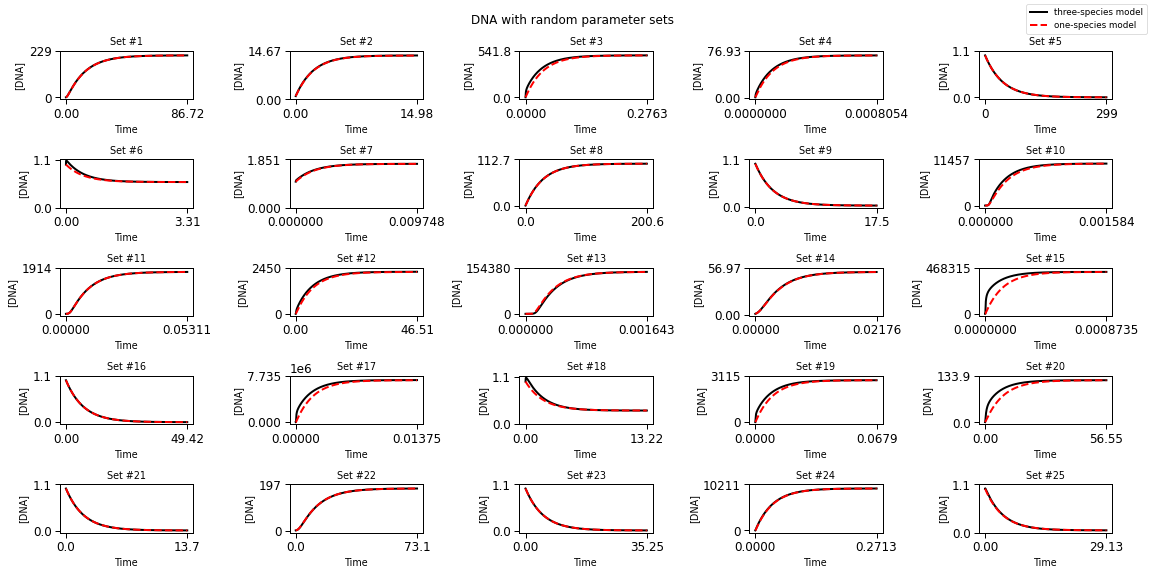

In [9]:
sqrt_iters = 5
iters = sqrt_iters ** 2
random.seed(3425)
species_inits = {"DNA": 1}

fig = plt.figure(figsize = (16,8))
plt.suptitle("DNA with random parameter sets")
for i in range(iters):
    ax = fig.add_subplot(sqrt_iters, sqrt_iters, i+1)
    temp_params = dict()
    semirandom_val = lambda:10 ** (random.random()*6 - 2)
    temp_params['k_gamma'] = semirandom_val()
    temp_params['k_p'] = temp_params['k_gamma'] * 10 ** (random.random()*2 + 1)
    temp_params['k_rep'] = temp_params['k_p'] * 10 ** (random.random()*2 + 1)
    temp_params['k_tx'] = temp_params['k_rep'] * 10 ** (random.random()*2 + 1)
    temp_params['k_gamma_I'] = temp_params['k_gamma'] * 10 ** (random.random()*2 + 1)
    # Sample log-parameters from U(-2,3).
    for param in ["k_I"]:#, "k_gamma_I"]:
        temp_params[param] = semirandom_val()
        
    # Simulate until steady-state.
    t_max = 10*np.log(2)/temp_params['k_gamma'] # Run out to ~10 doubling times
    ts = np.linspace(0, t_max, 1000)
    three_species_m = make_simplified_BP_model(temp_params, species_inits, lineage = False)
    one_species_m   = make_krep_large_BP_model(temp_params, species_inits, lineage = False)
    with warnings.catch_warnings():
        warnings.filterwarnings(action = "ignore")
        one_species_df = bs.simulator.py_simulate_model(ts, Model = one_species_m)
        three_species_df = bs.simulator.py_simulate_model(ts, Model = three_species_m)
        
    plt.subplot(sqrt_iters, sqrt_iters, i+1)
    # Plot trajectories
    three_species_tot_DNA = three_species_df["DNA"] + three_species_df["DNAp"]
    plt.plot(three_species_df['time'], three_species_tot_DNA, 
             color = 'black', lw = 2, label = "three-species model")
    plt.plot(one_species_df['time'], one_species_df["DNA"],
             color = 'red', 
             lw = 2, ls = "--", 
             label = "one-species model")
    
    ax.set_xticks([0, three_species_df['time'].max()])
    ax.set_yticks([0, one_species_df['DNA'].max()*1.1])
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)
    plt.xlabel("Time")
    plt.ylabel("[DNA]")
    plt.title("DNA over time")

    plt.title(f"Set #{i+1}")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

As we can see, this is a pretty good approximation. Unfortunately, this *isn't* the parameter regime we expect based on the literature (see parameterizations in `summary_table_plots.ipynb`). Also, because the propensity of DNA replication isn't a linear function of $DNA$, we have exited the world of CRNs with this model. 

#### 2) $k_p > k_{rep}$

Again we'll need a few assumptions for our reduction in this regime:
* $k_p > k_{rep}$
* $R$ dynamics are fast, and $R$ comes to instantaneous steady state. Fairly reasonable, since RNA degradation makes RNA dynamics generally fast compared to anything whose timescale is set by dilution.

In this regime, we can get a single-species reduction quite simply from the quasi-steady state estimate of $DNA_p$ used in our steady state analysis:

$$DNA_p = \frac{k_p(\gamma + \gamma_I)}{k_I(k_{tx} - k_p)}$$

Overall $DNA$ replication rate is then simply

$$k_{rep} * DNA_p = \frac{k_{rep}k_p(\gamma + \gamma_I)}{k_I(k_{tx} - k_p)}$$

In other words, replication rate is zero-order with respect to plasmid concentration -- a handy result! It does, however, mean that this model isn't, strictly speaking, a CRN model -- at least, not if we want to be able to track the identity of replicating DNA species. It seems we have come full circle back to the dummy-triggered repliation model. 

Again, we can test the approximation against a number of random-parameter simulations. Here we're choosing semirandom parameters so that:
* $k_{rep} > \gamma$
* $\gamma_I > \gamma$
* $k_{tx} > k_p > k_{rep}$

In [10]:
def make_kp_large_BP_model(params, initial_conditions, lineage = False):
    species = ["DNA"]

    rep_rate = "k_p * k_rep * (k_gamma + k_gamma_I) / k_I / (k_tx - k_p)"
    reactions = [
        (["DNA"], ["DNA", "DNA"], "general", {"rate": rep_rate}),
    ]
    
    if not lineage:
        for s in species:
            reactions.append(([s], [], "massaction", {"k": "k_gamma"}))
        return bs.types.Model(species = species, parameters = params, reactions = reactions,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(reactions, species, params, initial_conditions)
        return m

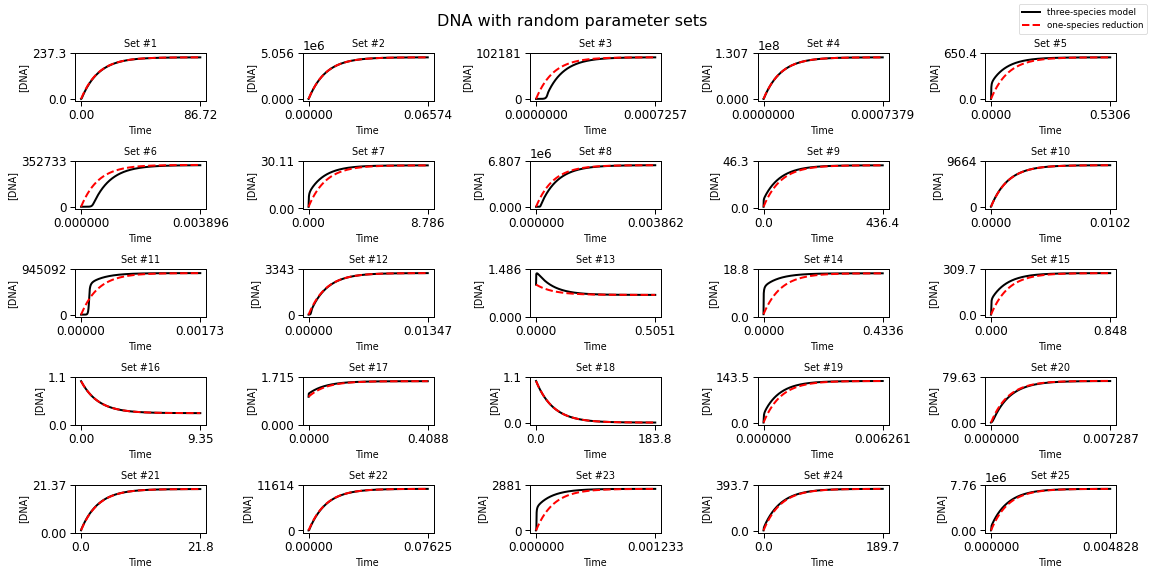

In [13]:
sqrt_iters = 5
iters = sqrt_iters ** 2
random.seed(3425)
species_inits = {"DNA": 1}

fig = plt.figure(figsize = (16,8))
plt.suptitle("DNA with random parameter sets", fontsize=16)
for i in range(iters):
    ax = fig.add_subplot(sqrt_iters, sqrt_iters, i+1)
    temp_params = dict()
    semirandom_val = lambda:10 ** (random.random()*6 - 2)
    temp_params['k_gamma'] = semirandom_val()
    temp_params['k_rep'] = temp_params['k_gamma'] * 10 ** (random.random()*2 + 1)
    temp_params['k_p'] = temp_params['k_rep'] * 10 ** (random.random()*2 + 1)
    temp_params['k_tx'] = temp_params['k_p'] * 10 ** (random.random()*2 + 1)
    temp_params['k_gamma_I'] = temp_params['k_gamma'] * 10 ** (random.random()*2 + 1)
    # Sample log-parameters from U(-2,3).
    for param in ["k_I"]:#, "k_gamma_I"]:
        temp_params[param] = semirandom_val()
        
    # Simulate until steady-state.
    t_max = 10*np.log(2)/temp_params['k_gamma'] # Run out to ~10 doubling times
    ts = np.linspace(0, t_max, 1000)
    three_species_m = make_simplified_BP_model(temp_params, species_inits, lineage = False)
    one_species_m   = make_kp_large_BP_model(temp_params, species_inits, lineage = False)
    with warnings.catch_warnings():
        warnings.filterwarnings(action = "ignore")
        one_species_df = bs.simulator.py_simulate_model(ts, Model = one_species_m)
        three_species_df = bs.simulator.py_simulate_model(ts, Model = three_species_m)
        
    plt.subplot(sqrt_iters, sqrt_iters, i+1)
    # Plot trajectories
    three_species_tot_DNA = three_species_df["DNA"] + three_species_df["DNAp"]
    plt.plot(three_species_df['time'], three_species_tot_DNA, 
             color = 'black', lw = 2, label = "three-species model")
    plt.plot(one_species_df['time'], one_species_df["DNA"],
             color =  'red', 
             lw = 2, ls = "--", 
             label = "one-species reduction")

    ax.set_xticks([0, three_species_df['time'].max()])
    ax.set_yticks([0, (three_species_df['DNA'] + three_species_df['DNAp']).max()*1.1])
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)
    plt.xlabel("Time")
    plt.ylabel("[DNA]")
    plt.title("DNA over time")

    plt.title(f"Set #{i+1}")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", "model_reduction_examples.png"), dpi=300)
plt.show()

Again, we have a pretty good approximation -- although certainly not a perfect one. 